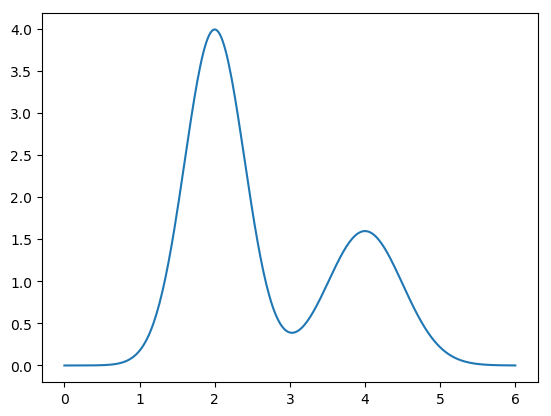

In [1]:
using PyCall
include("../src/gauss_error.jl")
include("../src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

# function phi(x::Float64)
#     return cos(x)
# end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))
savefig("function.png", dpi=1000)

In [2]:
function kernel(x::Float64, y::Float64)
    return getOpticsKernels("gaussian")(x, y)
end

kernel (generic function with 1 method)

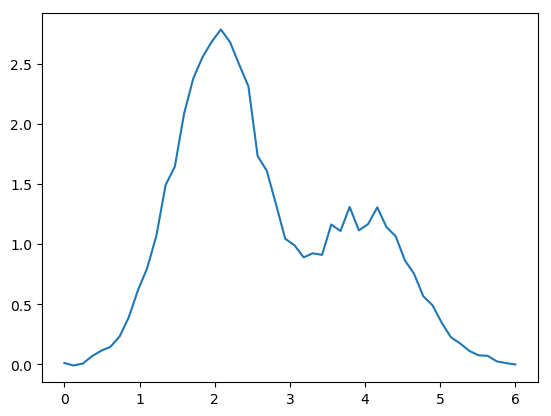

In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, maxevals=10^7)[1]
y = collect(range(a, stop = b, length=50))
ftrue = convolution.(y)
sig = 0.05*abs.(ftrue) +[0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
# f = [0.0250447, 0.0259323, 0.0300055, 0.0697762, 0.106568, 0.199481, 0.286887, 0.448353, 0.564742, 0.793431, 1.18831, 1.41718, 1.73265, 2.2737, 2.37566, 2.64492, 2.82908, 2.52841, 2.51898, 2.64624, 2.22185, 1.75508, 1.48881, 1.2669, 1.09605, 0.953436, 0.859025, 0.994736, 0.938362, 1.04007, 1.11036, 1.17168, 1.2502, 1.15296, 1.20842, 1.05919, 1.0105, 0.859411, 0.714523, 0.612392, 0.508907, 0.396421, 0.264456, 0.205983, 0.125906, 0.0530743, 0.0718868, 0.0308666, 0.0121104, 0.0207568]
plot(y, f)
savefig("integrated_function.png", dpi=1000)

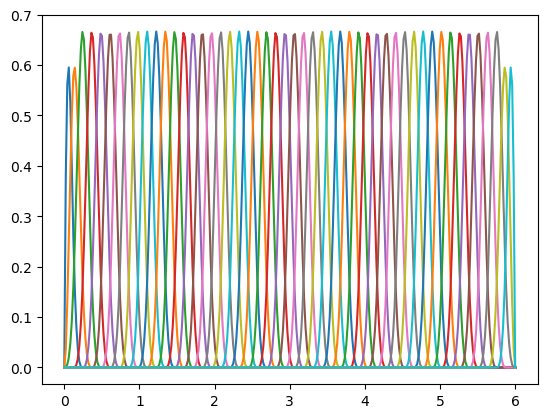

In [4]:
basis = CubicSplineBasis(y, "dirichlet")
for basis_function in basis.basis_functions
    plot(x, basis_function.f.(x))
end
savefig("basis.png", dpi=1000)

In [5]:
# @time discretize_kernel(basis, kernel, y)

Kmn = discretize_kernel(basis, kernel, y)

50×50 Array{Float64,2}:
 0.0564223    0.0806035    0.0965189    …  2.92235e-42  8.08106e-44
 0.0568853    0.0853341    0.108971        1.38854e-40  4.15223e-42
 0.0528153    0.0832629    0.113468        6.07839e-39  1.96507e-40
 0.0451581    0.0748768    0.108971        2.45149e-37  8.56574e-39
 0.0355576    0.0620605    0.0965189       9.10946e-36  3.43908e-37
 0.0257843    0.0474092    0.0788467    …  3.11879e-34  1.27179e-35
 0.017219     0.0333805    0.0594047       9.83828e-33  4.33195e-34
 0.0105901    0.0216627    0.0412783       2.85958e-31  1.3591e-32 
 0.0059983    0.0129576    0.0264535       7.65849e-30  3.92757e-31
 0.00312899   0.00714389   0.0156352       1.88996e-28  1.04544e-29
 0.00150324   0.00363032   0.0085227    …  4.29773e-27  2.5632e-28 
 0.000665135  0.00170043   0.0042845       9.00557e-26  5.78859e-27
 0.00027105   0.000734141  0.0019864       1.73891e-24  1.20413e-25
 ⋮                                      ⋱                          
 5.78859e-27  9.00557e-2

In [6]:
model = GaussErrorMatrixUnfolder(omega(basis, 2))

GaussErrorMatrixUnfolder(Array{Float64,2}[[13072.1 -3676.53 … 0.0 0.0; -3676.53 2451.02 … 0.0 0.0; … ; 0.0 0.0 … 2451.02 -3676.53; 0.0 0.0 … -3676.53 13072.1]], 50, "EmpiricalBayes", nothing)

starting solve
ending solve
starting solve_correct
starting optimal_alpha
starting optimize
Iter     Function value   Gradient norm 
     0    -7.676328e+02     2.511683e+01
     1    -7.913772e+02     8.569961e+00
     2    -8.043158e+02     1.012032e+00
     3    -8.044089e+02     2.386226e-02
     4    -8.044089e+02     2.898802e-07
     5    -8.044089e+02     1.882727e-07
     6    -8.044089e+02     4.183838e-08
     7    -8.044089e+02     1.195382e-08


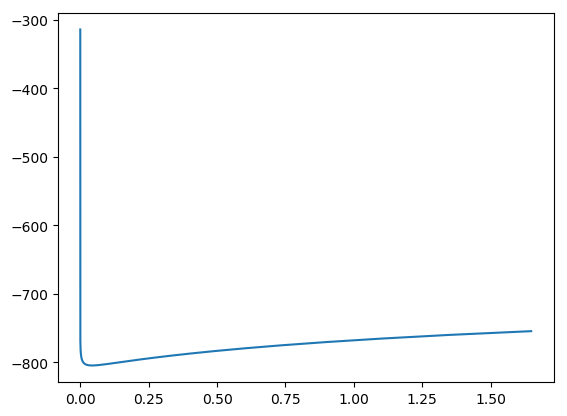

ending solve_correct


Dict{String,Array{Float64,N} where N} with 3 entries:
  "errors" => [0.00442107 0.00859493 … -1.54395e-6 -5.05128e-7; 0.00859493 0.02…
  "alphas" => [0.0432337]
  "coeff"  => [0.00288062, 0.00824225, -0.00236139, -0.03416, -0.0754514, -0.10…

In [7]:
# @time solve(model, Kmn, f, sig)

result = solve(model, Kmn, f, sig)

In [8]:
phivec = PhiVec(result, basis)

PhiVec([0.00288062, 0.00824225, -0.00236139, -0.03416, -0.0754514, -0.103124, -0.0875187, 0.00124951, 0.18658, 0.479514  …  0.30725, 0.154731, 0.0549005, 0.00251639, -0.0141321, -0.00980418, 0.00135663, 0.0089123, 0.00803823, 0.00272046], CubicSplineBasis(0.0, 6.0, [0.0, 0.0, 0.0, 0.0, 0.122449, 0.244898, 0.367347, 0.489796, 0.612245, 0.734694  …  5.26531, 5.38776, 5.5102, 5.63265, 5.7551, 5.87755, 6.0, 6.0, 6.0, 6.0], BaseFunction[BaseFunction(BSpline(1, 3, [0.0, 0.0, 0.0, 0.0, 0.122449, 0.244898, 0.367347, 0.489796, 0.612245, 0.734694  …  5.26531, 5.38776, 5.5102, 5.63265, 5.7551, 5.87755, 6.0, 6.0, 6.0, 6.0], ##41#43{Int64,Int64,Array{Float64,1}}(1, 3, [0.0, 0.0, 0.0, 0.0, 0.122449, 0.244898, 0.367347, 0.489796, 0.612245, 0.734694  …  5.26531, 5.38776, 5.5102, 5.63265, 5.7551, 5.87755, 6.0, 6.0, 6.0, 6.0], Box(#b_spline_function#42(Box(#= circular reference @-2 =#))))), (0.0, 6.0)), BaseFunction(BSpline(2, 3, [0.0, 0.0, 0.0, 0.0, 0.122449, 0.244898, 0.367347, 0.489796, 0.612245, 0.7

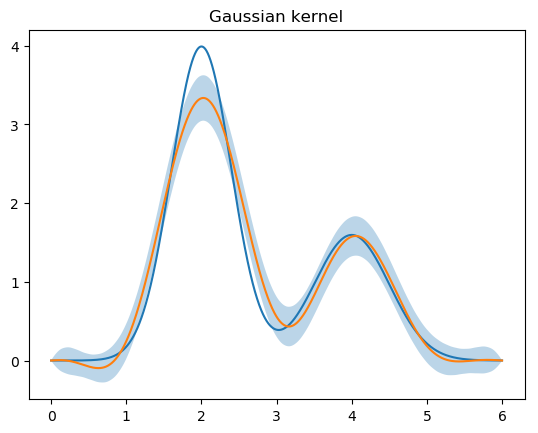

PyObject Text(0.5, 1.0, 'Gaussian kernel')

In [9]:
x = collect(range(a, stop=b, length=5000))
plot(x, phi.(x))

phi_reconstructed = call(phivec, x)
phi_reconstructed_errors = errors(phivec, x)

plot(x, call(phivec, x))
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)
title("Gaussian kernel")
# savefig("result.png", dpi=1000)

In [10]:
print(f)

[0.01055, -0.00965459, 0.00635945, 0.0674547, 0.113207, 0.145175, 0.231367, 0.391756, 0.617298, 0.800626, 1.07096, 1.4917, 1.64378, 2.08244, 2.3765, 2.55393, 2.68215, 2.78524, 2.68039, 2.49234, 2.31219, 1.73255, 1.60899, 1.32943, 1.04384, 0.990856, 0.889667, 0.923727, 0.910224, 1.16297, 1.10908, 1.3089, 1.11415, 1.16603, 1.30584, 1.14157, 1.06547, 0.864924, 0.752861, 0.566387, 0.491366, 0.346133, 0.225468, 0.173952, 0.112056, 0.0750837, 0.0703711, 0.0243228, 0.010213, -0.00103695]

In [13]:
print(result["errors"])

[0.00442107 0.00859493 0.00728808 0.00303615 -0.00124182 -0.00406661 -0.00503806 -0.00444131 -0.00288597 -0.001026 0.000617769 0.00173583 0.00223074 0.00216969 0.00171735 0.0010707 0.000408841 -0.000137407 -0.000496786 -0.00065401 -0.000636701 -0.000498101 -0.000299894 -9.81682e-5 6.58224e-5 0.000169652 0.000209071 0.000193987 0.000142689 7.58951e-5 1.1861e-5 -3.67285e-5 -6.39015e-5 -6.9848e-5 -5.92309e-5 -3.90034e-5 -1.63127e-5 3.0992e-6 1.57887e-5 2.07842e-5 1.91726e-5 1.33203e-5 5.98003e-6 -4.91438e-7 -4.64331e-6 -6.09582e-6 -5.37656e-6 -3.51769e-6 -1.54395e-6 -5.05128e-7; 0.00859493 0.0281242 0.0215236 0.00953833 -0.00353149 -0.0120304 -0.0150516 -0.0133413 -0.00873541 -0.00318359 0.00174785 0.0051232 0.00664008 0.00649064 0.00516179 0.00324054 0.00126318 -0.000376489 -0.00146196 -0.00194419 -0.00190312 -0.00149631 -0.000907601 -0.000304977 0.000187353 0.000501211 0.0006228 0.000580883 0.000429635 0.000230849 3.92457e-5 -0.000106923 -0.000189409 -0.00020842 -0.000177637 -0.00011771

111738 -0.000232099 -0.000366355 -0.000266227 -8.94809e-5; -0.000496786 -0.00146196 -0.00146276 0.000320401 0.00330373 0.00624437 0.00763516 0.00617738 0.00124501 -0.00675967 -0.0162523 -0.0245838 -0.0284542 -0.0246262 -0.0108271 0.0130363 0.0442304 0.074345 0.0951185 0.072862 0.0414913 0.00942975 -0.0148527 -0.028658 -0.0321654 -0.0277249 -0.0186008 -0.00806854 0.00125155 0.00773535 0.0108068 0.010766 0.00848624 0.00507636 0.00158414 -0.00120915 -0.00288539 -0.00338547 -0.00293041 -0.00190203 -0.000716967 0.000278291 0.000873831 0.00101786 0.000797109 0.00038734 -1.08391e-5 -0.000235748 -0.00021586 -7.31595e-5; -0.00065401 -0.00194419 -0.00262127 -0.00153625 0.0010934 0.0044218 0.00718758 0.0080353 0.00590039 0.000387473 -0.00794174 -0.0174519 -0.0255531 -0.0290848 -0.0249772 -0.0110988 0.0125738 0.043329 0.072862 0.093067 0.0704137 0.0389335 0.00708978 -0.01669 -0.029817 -0.0326123 -0.0275609 -0.0180228 -0.00731247 0.00196787 0.0082544 0.0110522 0.0107413 0.00825724 0.00474351 0.0012

00197e-5 -0.000119644 -0.000191023 -0.000226607 -0.000186002 -4.46093e-5 0.000191028 0.000475529 0.000727704 0.000845166 0.000728789 0.000312812 -0.000405509 -0.00134388 -0.00232779 -0.0031043 -0.00338038 -0.00288539 -0.00145127 0.000902973 0.00390281 0.00699157 0.00937071 0.0101247 0.00843126 0.00383247 -0.00348435 -0.0124725 -0.0211679 -0.0268663 -0.0266096 -0.0179402 -9.25887e-5 0.0252453 0.0508571 0.0695411 0.0482671 0.0210242 -0.00432983 -0.0204329 -0.0260138 -0.0226977 -0.0139962 -0.00381633 0.00455518 0.00909067 0.00921526 0.00564426 0.00188254; 3.0992e-6 8.20385e-6 -2.34293e-5 -9.35909e-5 -0.000172837 -0.000216532 -0.000181718 -4.40935e-5 0.000188737 0.000471323 0.00072411 0.000847484 0.000744601 0.000349505 -0.000344722 -0.00126419 -0.00224571 -0.00304779 -0.00338547 -0.00298935 -0.0016835 0.000530608 0.00340419 0.00641091 0.00878193 0.00962413 0.00812284 0.00380612 -0.00317936 -0.0118542 -0.0203406 -0.0260247 -0.026019 -0.0178925 -0.000840823 0.0235598 0.0482671 0.0662867 0.0

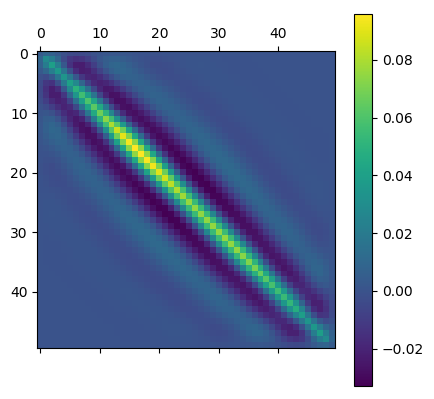

PyObject <matplotlib.colorbar.Colorbar object at 0x1a7e237f0>

In [14]:
matshow(result["errors"])
colorbar()